<div align="center"><font size="6">Freeze-Non freeze Products Classifier</font></div>

# 1. The Precios Cuidados Dataset

### Imports

In this section, I'm going to import all the required libraries for the Dataset preparation.
I will use methods from:

* python standard library
* sklearn
* numpy 
* matplotlib 
* pillow
* openCV
* h5py 
* Keras


In [1]:
from sklearn.datasets import load_files
from random import randint,shuffle
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import PIL.Image
import h5py
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array,array_to_img
from keras.utils import to_categorical

Using TensorFlow backend.


### Loading the Dataset

In the `data_dir`, I have stored all the data images separated in two folders: fridge and non-fridge.
I will use sklearn for loading the dataset. It will store the images and metadata information automatically, like the class of each image.

In [2]:
# Read the product images from the directory
data_dir  = "../data/preciosclaros_products"
bottleneck_features_dir = "../bottleneck_features"

print("Loading dataset from: ", data_dir,"\n")

# Store a sklearn dataset in raw_data. It includes metadata and the images.
raw_data = load_files(data_dir)

Loading dataset from:  ../data/preciosclaros_products 



### Exploring the Dataset

I will explore the dataset. I'm interested in how many images are in total and the quantity per class.

In [3]:
# Sklearn packged the images in a dictionary
print("Dataset keys: ",raw_data.keys())

# Reading the information form the sklearn dataset

# The list of filenames
filenames = raw_data['filenames']

# Each image to each class belogs. List of class_ids. 
target_classes = raw_data['target']

# The names of each class_id
target_names = raw_data['target_names']

# The files data, image data
data = raw_data['data']

raw_img_qty = len(filenames)

print("Dataset images qty:", raw_img_qty)
print("Classes qty:", len(target_names))
print("Classes names:", target_names)
print("\n")

print("# Products of each class:")

# I'm iterating the class_ids 
for c in range(len(target_names)):
    
    # filtering the products of the class_id c and taking lenght to know the quantity
    prod_qty = len([p for p in target_classes if p==c])
    print("{}: {} ({}%)".format(str(c)+": "+target_names[c], prod_qty, round(prod_qty/raw_img_qty,2)))
    

#  I will took a random image to know the shape    
raw_img_idx = randint(1,raw_img_qty)
filename = filenames[raw_img_idx]   
img = cv2.imread(filename)

print("\n")
print("Each image shape: ",img.shape)





Dataset keys:  dict_keys(['filenames', 'target', 'target_names', 'DESCR', 'data'])
Dataset images qty: 4685
Classes qty: 2
Classes names: ['fridge', 'non_fridge']


# Products of each class:
0: fridge: 683 (0.15%)
1: non_fridge: 4002 (0.85%)


Each image shape:  (240, 240, 3)


Let sample some products to see the images quality and what is stored in the Dataset

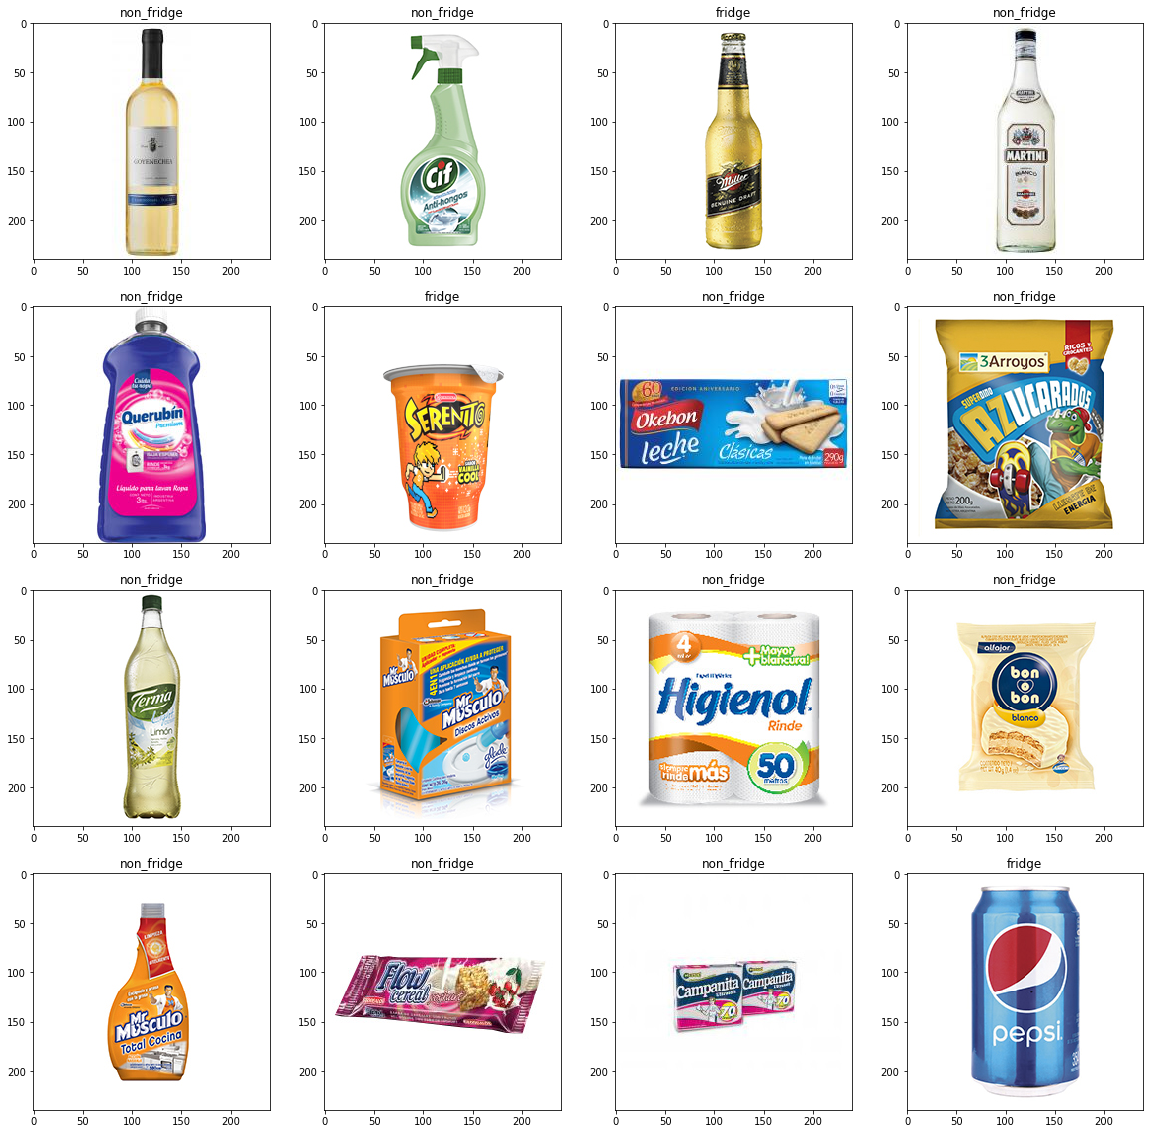

In [4]:
# Dataset images sampling
fig=plt.figure(figsize=(20, 20))

# I will use a columns x rows grid for displaying the images
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    
    # Using randint to select a random image
    raw_img_idx = randint(1,raw_img_qty)
    filename = filenames[raw_img_idx]
    target_class = target_classes[raw_img_idx]
    
    # Reading the image from file and applying a conversion, displaying images in matplotlib differs from storage.
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # I need to add a subplot for each image in matplot lib
    fig.add_subplot(rows, columns, i)
    
    # setting the title - I will use the classname
    plt.title(target_names[target_class])
    
    plt.imshow(img)
plt.show()


# 2. Dataset preparation

### Spliting the dataset

First, I will define which percentage of the data will be destinated to train, validation, and test.

In [4]:
train_pct = 0.75
val_pct = 0.15
test_pct = 0.1

assert(train_pct+val_pct+test_pct==1.0)

Auxiliary methods 

In [5]:
def split_train_val_test(ids, train_pct, val_pct):
    '''
    Splits the ids in train, valid, and test according to the specified percentages.
    
    Input:  ids - set of data indexes
            train_pct - % destinated to the train set
            val_pct - % destinated to the validation set
    
    Output: Tuple (train set, validation set, test set)
            Each component a list of ids
            
    '''
    total = len(ids)

    shuffle(ids)

    train_idx = int(train_pct*total)
    val_idx = int(val_pct*total)


    train_set  = ids[0:train_idx]
    val_set    = ids[train_idx:train_idx+val_idx]
    test_set  = ids[train_idx+val_idx:]
    
    return train_set, val_set, test_set

def merge_sets_and_shuffle(set1, set2):
    '''
    Merges two lists and returns shuffled the result
    '''
    set1 = set1+set2
    shuffle(set1)
    return set1

def get_set_stats(target_set, target_set_fridge, target_set_non_fridge, total):
    '''
    Returns the stats for a set (tuple):
        total
        percentage over all the images
        fridge quantity
        percentage fridge over total
        non-frige qty
        percentage non-fridge over total
    '''
    fridge_qty     = len(target_set_fridge) 
    non_fridge_qty = len(target_set_non_fridge)
    total_set = len(target_set)
    
    pct_total = round(total_set/total,2)
    pct_fridge = round(fridge_qty/total_set,2)
    pct_non_fridge= round(non_fridge_qty/total_set,2)
    
    return total_set, pct_total, fridge_qty, pct_fridge, non_fridge_qty, pct_non_fridge


In [6]:
## The idea is to build the sets keeping the proporsion of each class

# Separates the ids of the images according the class
fridge_ids     = [i for i,p in enumerate(target_classes) if p==0] 
non_fridge_ids = [i for i,p in enumerate(target_classes) if p==1] 


use_equal_parts = True
if use_equal_parts:
    non_fridge_ids = non_fridge_ids[:len(fridge_ids)]        

    
total = len(non_fridge_ids)+len(fridge_ids)

# Divides in sets according the percentage destinated for train, validation, and test set
train_set0, valid_set0, test_set0 = split_train_val_test(fridge_ids,train_pct,val_pct)
train_set1, valid_set1, test_set1 = split_train_val_test(non_fridge_ids,train_pct,val_pct)

# Merges both classes train, valid, and test sets to build a unique train, test, and valid set
train_set_ids = merge_sets_and_shuffle(train_set0, train_set1) 
valid_set_ids = merge_sets_and_shuffle(valid_set0, valid_set1) 
test_set_ids  = merge_sets_and_shuffle(test_set0, test_set1) 

# Priting some stats to see the results
print("Resultant sets stats:")


st = get_set_stats(train_set_ids, train_set0, train_set1, total)
print("Train Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(valid_set_ids, valid_set0, valid_set1, total)
print("Valid Set:  Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(test_set_ids, test_set0, test_set1, total)
print("Test Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))


Resultant sets stats:
Train Set: Total=1024 (0.75%) , Fridge=512 (0.5%), Non-Frige=512 (0.5%)
Valid Set:  Total=204 (0.15%) , Fridge=102 (0.5%), Non-Frige=102 (0.5%)
Test Set: Total=138 (0.1%) , Fridge=69 (0.5%), Non-Frige=69 (0.5%)


### Loading the images and labels (without data augmentation in memory)

In [7]:
tgt_image_size = (224,224,3)

def load_images_from_files(ids):
    '''
    Takes a list of images ids and returns the image data and label.
    It will resize it to 224x224x3 so it can be used in pre-trained models.
    
    Input:  ids - set of data indexes
    
    Output: Tuple (images, labels)
            images contains a list of 224x224x3 images
            labels contains a list of 0 (fridge) or 1 (non-fridge) indicating the class of the image i
    '''       
   
  
    # I'm creating empty numpy arrays, one for holding the images and the other one to hold the labels
    # I set the target shape
    images = np.ndarray(shape=(len(ids),)+tgt_image_size,dtype=float)
    labels = np.ndarray(shape=(len(ids),))
    
    for i, img_nbr in enumerate(ids):
        
        # I read the image data
        img = load_img(filenames[img_nbr])
        
        # Resizes the image       
        img = img.resize(tgt_image_size[:2])
        x = img_to_array(img)  
        
        # Update the numpy arrays with the image data and labels
        images[i] = x
        labels[i] = target_classes[img_nbr]
    
    labels = to_categorical(labels, len(target_names))
    return images,labels
        


Using the Ids I've separated, I will load all the images and labels information.

In [8]:
reload = True

if reload:
    # Loads from disk the image and labels for each train image
    pre_X_train,pre_y_train = load_images_from_files(train_set_ids)

    # Loads from disk the image and labels for each validation image
    pre_X_valid,pre_y_valid  = load_images_from_files(valid_set_ids)

    # Loads from disk the image and labels for each test image
    pre_X_test,pre_y_test  = load_images_from_files(test_set_ids)

    


print("-- Pre processed Train dataset --")
print("Dataset shape: ", pre_X_train.shape)
print("Labels shape:", pre_y_train.shape)

print("-- Pre processed Test dataset --")
print("Dataset shape: ", pre_X_valid.shape)
print("Labels shape:", pre_y_valid.shape)

print("-- Pre processed Validate  dataset --")
print("Dataset shape: ", pre_X_test.shape)
print("Labels shape:", pre_y_test.shape)



-- Pre processed Train dataset --
Dataset shape:  (1024, 224, 224, 3)
Labels shape: (1024, 2)
-- Pre processed Test dataset --
Dataset shape:  (204, 224, 224, 3)
Labels shape: (204, 2)
-- Pre processed Validate  dataset --
Dataset shape:  (138, 224, 224, 3)
Labels shape: (138, 2)


### Define the data transformation to be applied (Data Augmentation)

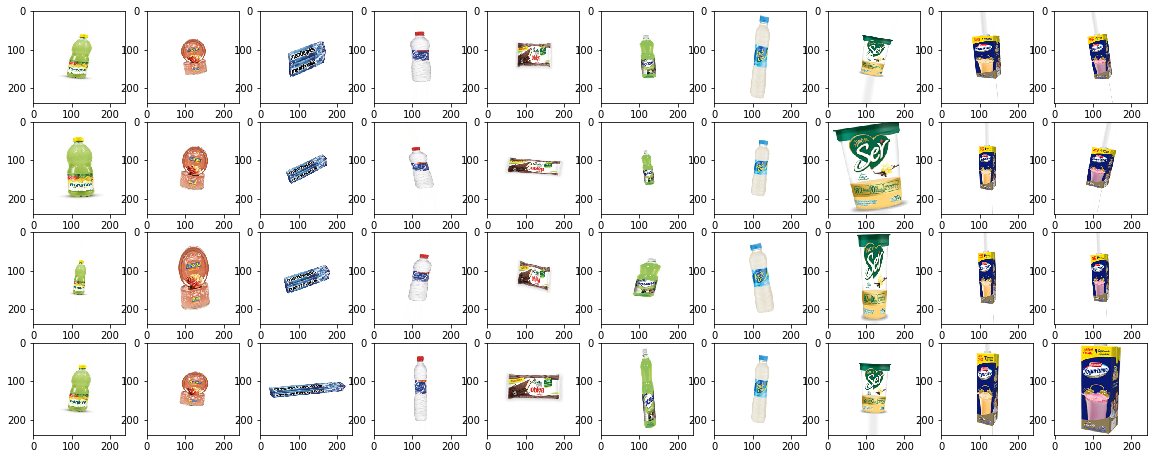

In [9]:
import PIL.Image
from keras.applications.vgg19 import preprocess_input
datagen = ImageDataGenerator(
        rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        shear_range=0.5,
        zoom_range=[1,2.5],
        rescale=1./255,
        #preprocessing_function=preprocess_input,
        #horizontal_flip=True,
        fill_mode='nearest')

e = np.ndarray(shape=(10,240,240,3))
j = 0
for i in test_set_ids[1:11]:
    img = load_img(filenames[i])  
    x = img_to_array(img)  
    e[j] = x
    j=j+1

fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 10

j = 0
for batch in datagen.flow(e, batch_size=1, shuffle=False):
    j += 1
    if j > 40:
        break 
        
    xi = array_to_img(batch[0])
    fig.add_subplot(rows, columns, j)

    plt.imshow(xi)
        
        
plt.show()   
    

### The data generators creation (Data Augmentation)

In [10]:
train_datagen = datagen 

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(pre_X_train)
valid_datagen.fit(pre_X_valid)
test_datagen.fit(pre_X_test)

## 3. Model Building: Benchmark Model 

### Modeling imports

In [12]:
from keras.layers import  Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D,MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD,Adamax,Adagrad
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from math import ceil


### Bottleneck features extraction : data preprocessing

In [21]:
def extract_features(datagen, pre_trained_model_type, X, y, batch_size, aug_images_nbr, filename):
    generator = datagen.flow(X, y, batch_size=batch_size, shuffle=False)

    model = pre_trained_model_type(input_shape=X.shape[1:],include_top=False)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    bottleneck_features = model.predict_generator(generator,  steps=aug_images_nbr*len(X)//batch_size, max_queue_size=10, workers=1, use_multiprocessing=True, verbose=1)
    print("Bottleneck features shape: ",bottleneck_features.shape)
    np.save(filename, bottleneck_features)
    

In [22]:
def generate_bottleneck_features(model_type, batch_size=32, data_augmented_images=8):
    model_name = model_type.__name__
    print("Generating features for model "+model_name)
    extract_features(train_datagen, model_type, pre_X_train, pre_y_train,batch_size, data_augmented_images,model_name+"_train.npy")
    extract_features(valid_datagen, model_type, pre_X_valid, pre_y_valid,batch_size, data_augmented_images,model_name+"_valid.npy")
    extract_features(test_datagen, model_type, pre_X_test, pre_y_test,batch_size, 1,model_name+"_test.npy")
 
#generate_bottleneck_features(VGG19)
#generate_bottleneck_features(VGG16)
#generate_bottleneck_features(ResNet50)
#generate_bottleneck_features(Xception,data_augmented_images=4)
#generate_bottleneck_features(InceptionV3)




Generating features for model ResNet50
256/256 [==============================] - 62s 242ms/step
Bottleneck features shape:  (8192, 1, 1, 2048)
51/51 [==============================] - 9s 178ms/step
Bottleneck features shape:  (1492, 1, 1, 2048)
4/4 [==============================] - 2s 410ms/step
Bottleneck features shape:  (128, 1, 1, 2048)


### Benchmark Model 

In [15]:
model_type = VGG16

def load_bottleneck(filename,pre_y):
    X = np.load(filename)
    
    labels_length = len(pre_y)
    X_length = len(X)
    
    times = ceil(X_length / labels_length)
    
    y = np.tile(pre_y, (times,1))[:X_length]
    
    return X,y

def load_bottleneck_class(model_type):
    model_name = model_type.__name__
    X_train, y_train = load_bottleneck(model_name+"_train.npy",pre_y_train)
    X_valid, y_valid = load_bottleneck(model_name+"_valid.npy",pre_y_train)
    X_test, y_test = load_bottleneck(model_name+"_test.npy",pre_y_train)
    
    return  X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_bottleneck_class(model_type)    
    
    

In [16]:
bench_model = Sequential()
bench_model.add(GlobalAveragePooling2D(input_shape=X_train.shape[1:]))
bench_model.add(Dense(2, activation='softmax'))
bench_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [18]:
have_to_train_benchmark = False
def train_benchmark(filename):

    epochs = 200
    batch_size = 64


    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    #adamax = Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    bench_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    
    if have_to_train_benchmark:
        checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]


        bench_model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

def train_benchmark_model(model_type, load_bottleneck=True):
    if load_bottleneck:
        load_bottleneck_class(model_type)
        
    model_name = model_type.__name__
    train_benchmark(model_name+".weights.best.hdf5")
        
train_benchmark_model(model_type)

## 4. Model Building: Product detector from the scratch

### Preparing Data Generators for Data Augmentation

In [97]:
batch_size = 128
train_generator = train_datagen.flow(pre_X_train, pre_y_train, batch_size=batch_size, shuffle=False)
valid_generator = valid_datagen.flow(pre_X_valid, pre_y_valid, batch_size=batch_size, shuffle=False)
test_generator = test_datagen.flow(pre_X_test, pre_y_test, batch_size=batch_size, shuffle=False)



### Defining the model

In [98]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, strides=1, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
#model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 27, 27, 64)        0         
__________

In [16]:
'''
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, strides=1, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 27, 27, 64)        0         
__________

"\nmodel = Sequential()\n\nmodel.add(Conv2D(filters=16, kernel_size=2, strides=1, activation='relu', input_shape=(224, 224, 3)))\nmodel.add(MaxPooling2D(pool_size=2, strides=2))\nmodel.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))\nmodel.add(MaxPooling2D(pool_size=2, strides=2))\nmodel.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))\nmodel.add(MaxPooling2D(pool_size=2, strides=2))\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))\nmodel.add(MaxPooling2D(pool_size=2, strides=2))\nmodel.add(Flatten())\nmodel.add(Dense(64,activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(2, activation='softmax'))\n\nmodel.summary()\n"

### Training the model

In [99]:
train_model = False
epochs = 300
val_epochs=800
batch_size = 64

#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adamax = Adamax(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])

if train_model:
    filepath="model_weights.best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=epochs // batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=valid_generator,
            validation_steps=800 // batch_size)

## 5. Predictions Stats

### Bechmark Testing and Stats

In [79]:
model_type = VGG16
model_name = model_type.__name__

bench_model.load_weights(model_name+".weights.best.hdf5")
print("Loaded model from disk")
 
score = bench_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (bench_model.metrics_names[1], score[1]*100))



Loaded model from disk
acc: 47.10%


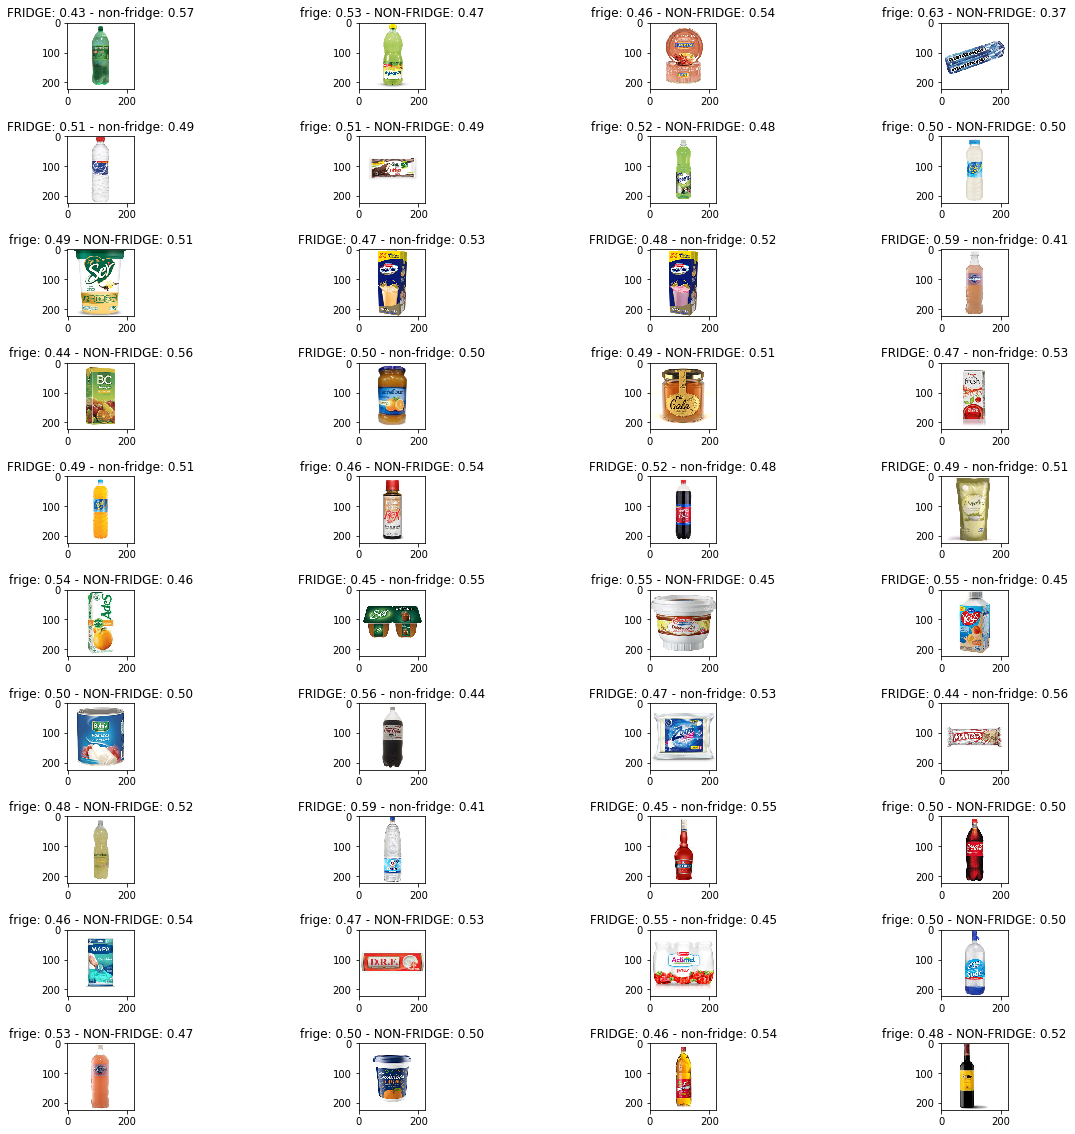

In [83]:
prediction = bench_model.predict(X_test)

columns = 4
rows = 10
fig=plt.figure(figsize=(20, 20))

for i,pred in enumerate(prediction[0:40]):
    fig.add_subplot(rows, columns, i+1)
    plt.subplots_adjust( hspace=0.70)
    
    xi = array_to_img(pre_X_test[i])
    plt.imshow(xi)
   
    if y_test[i][0] == 1:
        plt.title("FRIDGE: {:1.2f} - non-fridge: {:1.2f}".format(pred[0],pred[1]))
    else:
        plt.title("frige: {:1.2f} - NON-FRIDGE: {:1.2f}".format(pred[0],pred[1]))
   
    

#### Confusion Matrix and F1-Score

In [100]:
def generate_f1_score(prediction, y):
    predicted_labels = [np.argmax(y_hat) for y_hat in prediction]
    print(prediction.shape)
    matrix = dict()

    matrix['fridge'] = dict()
    matrix['non-fridge'] = dict()


    matrix['fridge']['fridge'] = 0
    matrix['fridge']['non-fridge'] = 0
    matrix['non-fridge']['fridge'] = 0
    matrix['non-fridge']['non-fridge'] = 0


    for i in range(len(predicted_labels)):
        matrix['fridge']['fridge'] += int(predicted_labels[i] == 0 and y[i][0] == 1)
        matrix['fridge']['non-fridge'] += int(predicted_labels[i] == 1 and y[i][0] == 1)
        matrix['non-fridge']['fridge'] += int(predicted_labels[i] == 0 and y[i][1] == 1)
        matrix['non-fridge']['non-fridge'] += int(predicted_labels[i] == 1 and y[i][1] == 1)

    tot_fridge = matrix['fridge']['fridge']+matrix['fridge']['non-fridge']
    tot_non_fridge = matrix['non-fridge']['fridge']+matrix['non-fridge']['non-fridge']

    tot_pred_fridge = matrix['fridge']['fridge']+matrix['non-fridge']['fridge']
    tot_pred_non_fridge = matrix['non-fridge']['non-fridge']+matrix['fridge']['non-fridge']

    print('Confusion Matrix:\n')
  
    print('--------------------------------------------------------------------------')
    print('              |  fridge       | non-fridge           |   Total            ')
    print('-----------------------------------------------------|--------------------')
    print('   fridge     |      {}       |     {}             |          {}        |'.format(matrix['fridge']['fridge'],matrix['fridge']['non-fridge'],tot_fridge ))
    print('   non-fridge |      {}       |     {}             |           {}       |'.format(matrix['non-fridge']['fridge'],matrix['non-fridge']['non-fridge'],tot_non_fridge ))
    print('-----------------------------------------------------|-------------------')
    print('   Total      |      {}       |     {}             |                     |'.format(tot_pred_fridge,tot_pred_non_fridge ))


    # calculating the precision
    precision = matrix['fridge']['fridge'] / tot_pred_fridge

    print("\nHow many of the products predicted to go to the fridge actually needs to go in the fridge?")
    print("Precision: {0:.2f}%".format(precision*100))
    
    # calculating the recall
    recall = matrix['fridge']['fridge'] / tot_fridge

    print("\nOf the fridge items, how many were correctly predicted")
    print("Recall: {0:.2f}%".format(recall*100))
    
    # calculating f1 score
    f1_score = 2*(precision*recall / (precision+recall) )
    print("\nF1-Score: {0:.2f}".format(f1_score))
    
generate_f1_score(prediction, y_test)    

(138, 2)
Confusion Matrix:

--------------------------------------------------------------------------
              |  fridge       | non-fridge           |   Total            
-----------------------------------------------------|--------------------
   fridge     |      31       |     42             |          73        |
   non-fridge |      16       |     49             |           65       |
-----------------------------------------------------|-------------------
   Total      |      47       |     91             |                     |

How many of the products predicted to go to the fridge actually needs to go in the fridge?
Precision: 65.96%

Of the fridge items, how many were correctly predicted
Recall: 42.47%

F1-Score: 0.52


### Model Testing and Stats

In [101]:
model.load_weights("model_weights.best.hdf5")
print("Loaded model from disk")
 
score = model.evaluate_generator(test_generator)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


Loaded model from disk
acc: 57.97%


(138, 2)


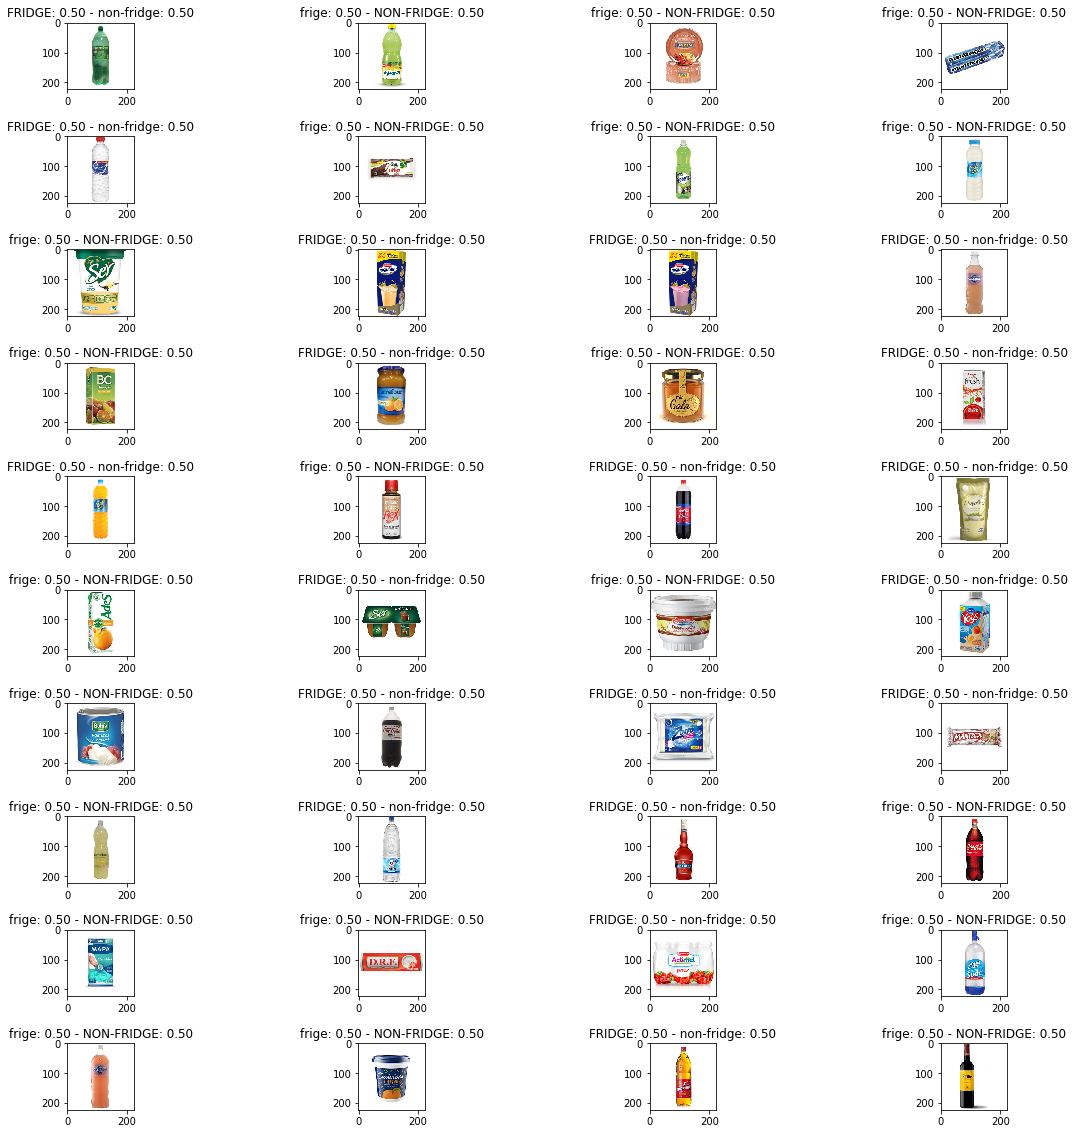

In [102]:
prediction = model.predict_generator(test_generator)
print(prediction.shape)

columns = 4
rows = 10
fig=plt.figure(figsize=(20, 20))

for i,pred in enumerate(prediction[0:40]):
    fig.add_subplot(rows, columns, i+1)
    plt.subplots_adjust( hspace=0.70)
    
    xi = array_to_img(pre_X_test[i])
    plt.imshow(xi)
    if y_test[i][0] == 1:
        plt.title("FRIDGE: {:1.2f} - non-fridge: {:1.2f}".format(pred[0],pred[1]))
    else:
        plt.title("frige: {:1.2f} - NON-FRIDGE: {:1.2f}".format(pred[0],pred[1]))
   
    

In [103]:
generate_f1_score(prediction, y_test)  



(138, 2)
Confusion Matrix:

--------------------------------------------------------------------------
              |  fridge       | non-fridge           |   Total            
-----------------------------------------------------|--------------------
   fridge     |      31       |     42             |          73        |
   non-fridge |      16       |     49             |           65       |
-----------------------------------------------------|-------------------
   Total      |      47       |     91             |                     |

How many of the products predicted to go to the fridge actually needs to go in the fridge?
Precision: 65.96%

Of the fridge items, how many were correctly predicted
Recall: 42.47%

F1-Score: 0.52
